In [1]:
import numpy as np
from make_galaxy import Galaxy
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from tqdm import tqdm

#plt.style.use('dark_background')
#get_ipython().run_line_magic('matplotlib', 'qt')

# Generate a Galaxy

In [2]:
gal = Galaxy(kpc_size=17.5, b=-0.3, num_arms=2, rot_spacing=None, trail_delay=0.1, fuzz=1.5, nr_core_part=3000, nr_arm_part=1000, nr_haze_part=2000)

arms_info = gal.arms_info
build = gal.build_galaxy(r_in=2, z_in=0.5, r_out=1, z_out=0.3)

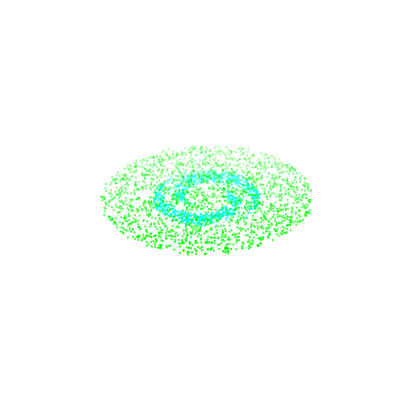

In [3]:
# Plot stars in 3D using matplotlib:
fig, ax = plt.subplots(figsize=(5, 5), ncols=1, nrows=1, subplot_kw={'projection': '3d'})
ax.set_axis_off()
ax.set_zlim (-15, 15)

leading_arm = build['leading_arm']
trailing_arm = build['trailing_arm']
core_parts = build['core_parts']
inner_haze = build['inner_haze']
outer_haze = build['outer_haze']

ax.scatter(*zip(*leading_arm), c='w', marker='.', s=5)
ax.scatter(*zip(*trailing_arm), c='w', marker='.', s=2)
ax.scatter(*zip(*core_parts), c='yellow', marker='.', s=1)
ax.scatter(*zip(*inner_haze), c='cyan', marker='.', s=1)
ax.scatter(*zip(*outer_haze), c='lime', marker='.', s=1)

In [4]:
arms_info

[(0.0, 1.5), (-0.1, 1.5), (1.0, 1.5), (0.9, 1.5)]

In [5]:
parts = gal.get_particles(r_in=2, z_in=0.5, r_out=1, z_out=0.3)

arm_particles = parts['arm']
core_particles = parts['core']
haze_particles = parts['haze']

In [6]:
g_part = np.vstack((np.vstack((arm_particles, core_particles)), haze_particles))

min_x, min_y, min_z = g_part.min(axis=0)
max_x, max_y, max_z = g_part.max(axis=0)

## Create a refined mesh grid

In [7]:
def refine_grid_3d(HII_DIM, refine_cells, levels):
    """
    Generate a 3D grid with refinement at specified cells.
    
    If a cell is refined, it is replaced by its refined sub-cells.

    Parameters:
        HII_DIM (int): Coarse grid size.
        refine_cells (list): List of (i, j) cells to refine.
        levels (dict): Mapping (i, j) -> refinement level.

    Returns:
        x_grid (np.array): x-coordinates of final cells (lower-left corner).
        y_grid (np.array): y-coordinates of final cells.
        z_grid (np.array): z-coordinates of final cells.
        dr (np.array): size of each final cell.
    """
    x_grid = []
    y_grid = []
    z_grid = []
    dr = []
    
    for i in range(HII_DIM):
        for j in range(HII_DIM):
            for k in range(HII_DIM):
                if (i, j, k) in refine_cells:
                    level = levels[(i, j, k)]
                    sub_divs = 2**level
                    dx = 1.0 / sub_divs

                    # Refine cell into sub_divs × sub_divs sub-cells
                    x_sub_cells = np.linspace(i, i + 1, 2**(level+1) + 1)[1:-1]
                    y_sub_cells = np.linspace(j, j + 1, 2**(level+1) + 1)[1:-1]
                    z_sub_cells = np.linspace(k, k + 1, 2**(level+1) + 1)[1:-1]

                    for x in x_sub_cells:
                        for y in y_sub_cells:
                            for z in z_sub_cells:
                                if(x % dx != 0 and y % dx != 0 and z % dx != 0):
                                    x_grid.append(x)
                                    y_grid.append(y)
                                    z_grid.append(z)
                                    dr.append(dx)
                else:
                    # Only keep coarse cell if it was NOT refined
                    x_grid.append(i+0.5)
                    y_grid.append(j+0.5)
                    z_grid.append(k+0.5)
                    dr.append(1.0)
    
    return np.array(x_grid), np.array(y_grid), np.array(z_grid), np.array(dr)


def plot_irregular_grid_cells(r_c, dr, color='white', ax=None):
    patches = []
    
    for i_c in tqdm(range(r_c.shape[0])):
        x0 = r_c[i_c,0]-dr[i_c]/2
        y0 = r_c[i_c,1]-dr[i_c]/2
        rect = Rectangle((x0, y0), dr[i_c], dr[i_c])
        patches.append(rect)

        collection = PatchCollection(patches, edgecolor='black', facecolor=color, linewidth=0.8, alpha=1.0)
        ax.add_collection(collection)
        ax.autoscale()
        ax.set_aspect('equal')

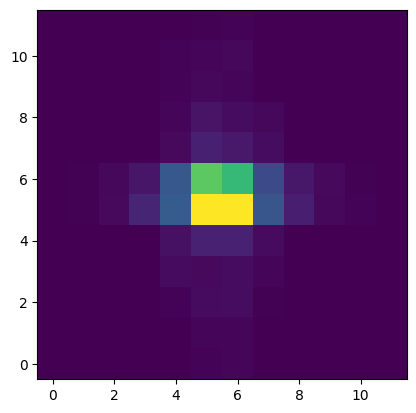

[[0.000e+00 0.000e+00 1.000e+00 7.000e+00 1.300e+01 1.200e+01 8.000e+00
  2.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 8.000e+00 1.500e+01 1.000e+01 7.000e+00 5.000e+00
  1.400e+01 7.000e+00 4.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.300e+01 1.200e+01 5.000e+00 4.000e+00 8.000e+00 1.100e+01
  8.000e+00 1.000e+01 8.000e+00 9.000e+00 0.000e+00]
 [2.000e+00 1.200e+01 2.000e+01 9.000e+00 2.300e+01 3.000e+01 4.200e+01
  4.100e+01 1.800e+01 9.000e+00 6.000e+00 5.000e+00]
 [8.000e+00 2.100e+01 1.500e+01 3.700e+01 5.400e+01 4.200e+01 4.600e+01
  3.700e+01 4.000e+01 1.700e+01 1.100e+01 1.100e+01]
 [1.300e+01 1.700e+01 1.400e+01 3.200e+01 5.700e+01 1.061e+03 7.640e+02
  4.700e+01 2.500e+01 1.500e+01 1.000e+01 8.000e+00]
 [9.000e+00 1.100e+01 2.300e+01 2.300e+01 6.700e+01 7.240e+02 4.850e+02
  5.000e+01 2.500e+01 1.400e+01 1.500e+01 8.000e+00]
 [6.000e+00 1.100e+01 1.100e+01 2.900e+01 2.500e+01 4.500e+01 4.600e+01
  5.500e+01 1.500e+01 9.000e+00 1.900e+01 7.000e+00]


<Figure size 640x480 with 0 Axes>

In [18]:
from scipy import stats

HII_DIM = 12
dL = 60.
boxsize = HII_DIM * dL

# Create initial 3D grid (no specific refinement)
bin_x = np.linspace(min_x, max_x, HII_DIM+1)
bin_y = np.linspace(min_y, max_y, HII_DIM+1)
bin_z = np.linspace(min_z, max_z, HII_DIM+1)

N = stats.binned_statistic_dd(g_part, np.arange(g_part.shape[0]), bins=[bin_x, bin_y, bin_z], statistic='count').statistic
plt.imshow(N[HII_DIM//2], origin='lower')
plt.show(), plt.clf()

print(N[...,HII_DIM//2])
"""
refine_cells = []
levels = []

x_grid, y_grid, z_grid, dr = refine_grid_3d(HII_DIM=HII_DIM, refine_cells=refine_cells, levels=levels)
#bin_x, bin_y, bin_z = (x_grid - dr/2)/HII_DIM*boxsize, (y_grid - dr/2)/HII_DIM*boxsize, (z_grid - dr/2)/HII_DIM*boxsize

""";

In [15]:
from scipy import stats

HII_DIM = 12
dL = 60.
boxsize = HII_DIM * dL

# Create initial 3D grid (no specific refinement)
bin_x = np.linspace(min_x, max_x, HII_DIM+1)
bin_y = np.linspace(min_y, max_y, HII_DIM+1)
bin_z = np.linspace(min_z, max_z, HII_DIM+1)
print(bin_x.size)

count_lvl = 1
condition = True
while condition:
    N = stats.binned_statistic_dd(g_part, np.arange(g_part.shape[0]), bins=[bin_x, bin_y, bin_z], statistic='count').statistic

    indexes = np.array(np.where((N > 250))).T
    print(indexes.size)
    
    if(indexes.size > 0):
        refine_cells = []
        lvl = []

        for idx in indexes:
            refine_cells.append((idx[0], idx[1], idx[2]))
            lvl.append(count_lvl)

        levels = {ref: lvl[l] for l, ref in enumerate(refine_cells)}

        x_grid, y_grid, z_grid, dr = refine_grid_3d(HII_DIM=HII_DIM, refine_cells=refine_cells, levels=levels)
        
        bin_x = np.append(np.unique((x_grid-dr/2)*dL), (x_grid[-1]+dr[-1]/2)*dL) - boxsize/2
        bin_y = np.append(np.unique((y_grid-dr/2)*dL), (y_grid[-1]+dr[-1]/2)*dL) - boxsize/2
        bin_z = np.append(np.unique((z_grid-dr/2)*dL), (z_grid[-1]+dr[-1]/2)*dL) - boxsize/2 
        
        count_lvl += 1
        condition = True
        
    else:
        condition = False

13
33
24
30
0


In [16]:
x_grid.size

6838

100%|███████████████████████████████████████| 2188/2188 [01:16<00:00, 28.59it/s]


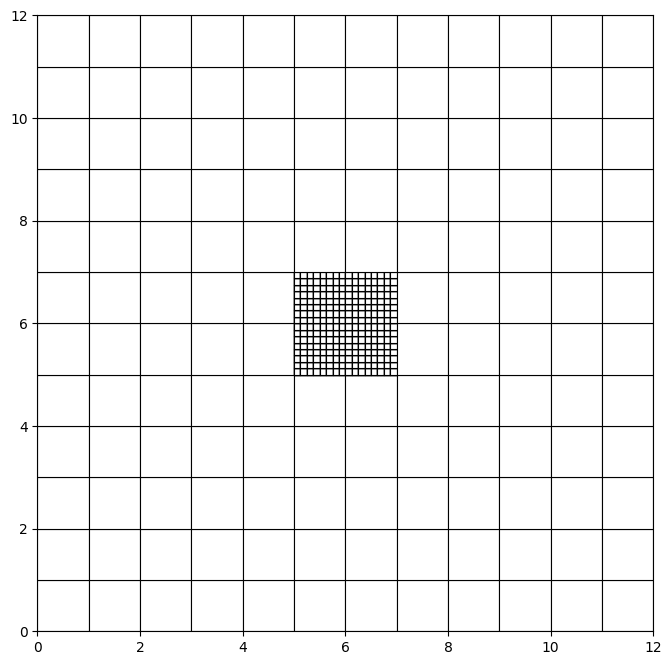

(None, None)

<Figure size 640x480 with 0 Axes>

In [17]:
r_c = np.vstack((x_grid.ravel(), y_grid.ravel(), z_grid.ravel())).T

# Select indices where z ≈ z_slice
z_slice = HII_DIM//2+0.5
tol = 0.5
mask = np.abs(r_c[:, 2] - z_slice) < tol

# Get unique 2D coordinates and a mask
r_c_slice = r_c[mask, :2]  # only x, y
dr_slice = dr[mask]

fig, ax = plt.subplots(figsize=(8, 8))
#plot_irregular_grid_cells(r_c, dr, color='white', ax=ax)
plot_irregular_grid_cells(r_c_slice, dr_slice, color='white', ax=ax)
    
ax.set_xlim([0, HII_DIM])
ax.set_ylim([0, HII_DIM])
plt.show(), plt.clf()
